/var/folders/b4/spskmk5x6xggprwkxqclxbb40000gn/T/ipykernel_49514/3426830790.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


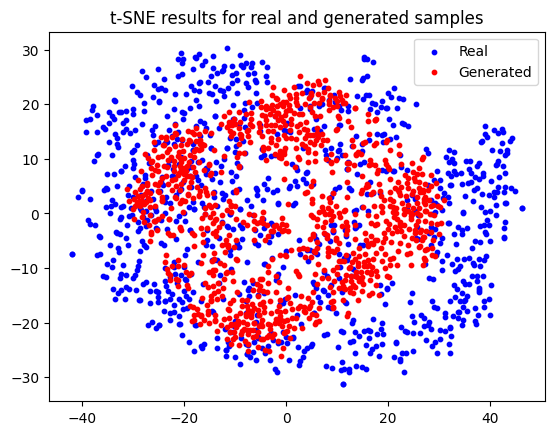

In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd



def time_series_to_2d_points(time_series):
    # Initialize t-SNE
    tsne = TSNE(n_components=2)

    # Fit and transform the data to the first two components
    two_d_points = tsne.fit_transform(time_series)

    return two_d_points

# Retrieves the real and generated samples

# import the normalized slices
slices = pd.read_csv('data/slices_normalized.csv', index_col=0)
real_samples = slices.sample(1000)  # Use 10000 random real slices
generated_samples = pd.read_csv('data/generated_samples.csv').values  # Load the generated samples from the CSV file

# Convert the samples to 2D points
real_points = time_series_to_2d_points(real_samples)
generated_points = time_series_to_2d_points(generated_samples)

# Plot the t-SNE results
plt.scatter(real_points[:, 0], real_points[:, 1], color='blue', label='Real', s=10)
plt.scatter(generated_points[:, 0], generated_points[:, 1], color='red', label='Generated', s=10)
plt.legend() 
# Add a title
plt.title('t-SNE results for real and generated samples')

plt.show()

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# Assume `discriminator` is a Logistic Regression model
discriminator = LogisticRegression()

# Label real samples as 1 and generated samples as 0
real_labels = np.ones((len(real_samples), 1))
generated_labels = np.zeros((len(generated_samples), 1))

# Concatenate the real and generated samples and labels
all_samples = np.concatenate([real_samples, generated_samples])
all_labels = np.concatenate([real_labels, generated_labels])

# Train the discriminator
discriminator.fit(all_samples, all_labels.ravel())

# Use the discriminator to predict the labels of all samples
predicted_labels = discriminator.predict(all_samples)

# Compute the discriminative score (accuracy of the discriminator)
discriminative_score = accuracy_score(all_labels, predicted_labels)

# Compute the generative score (accuracy of the generator)
generative_score = accuracy_score(generated_labels, predicted_labels[len(real_samples):])

print(f"Discriminative score: {discriminative_score}")
print(f"Generative score: {generative_score}")

Discriminative score: 0.663
Generative score: 0.63


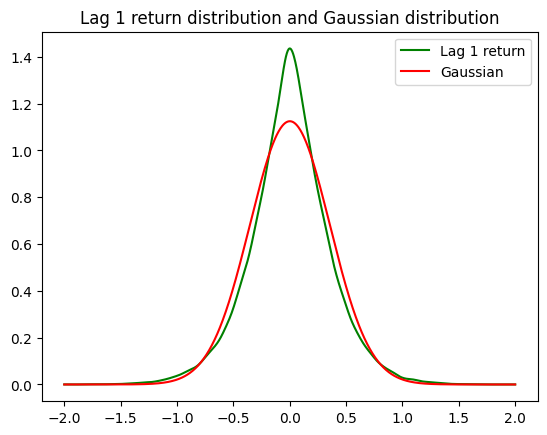

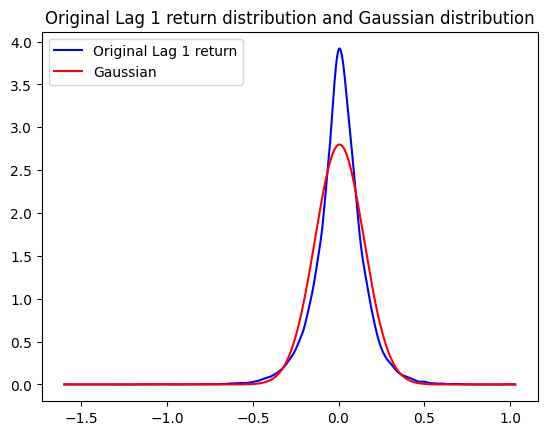

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

# Load the generated samples from the CSV file
generated_samples = pd.read_csv('data/generated_samples.csv').values

# Calculate the lag 1 return for each time series
lag_1_returns = [np.diff(time_series) for time_series in generated_samples]

# Flatten the returns to 1D
lag_1_returns = np.concatenate(lag_1_returns)

# Calculate the mean and standard deviation of the returns
mean = np.mean(lag_1_returns)
std = np.std(lag_1_returns)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian = norm(loc=mean, scale=std)

# Generate values for the x axis
x = np.linspace(min(lag_1_returns), max(lag_1_returns), 1000)

# Estimate the density function of the lag 1 return using KDE
kde = gaussian_kde(lag_1_returns)
lag_1_return_density = kde(x)

# Plot the density function of the lag 1 return
plt.plot(x, lag_1_return_density, color='g', label='Lag 1 return')

# Plot the Gaussian distribution
plt.plot(x, gaussian.pdf(x), 'r', label='Gaussian')

plt.title('Lag 1 return distribution and Gaussian distribution')
plt.legend()
plt.show()

# Load the original data from the CSV file
original_samples = slices.sample(1000).values

# Calculate the lag 1 return for each slicing window
lag_1_returns_original = [np.diff(time_series) for time_series in original_samples]

# Flatten the returns to 1D
lag_1_returns_original = np.concatenate(lag_1_returns_original)

# Calculate the mean and standard deviation of the returns
mean_original = np.mean(lag_1_returns_original)
std_original = np.std(lag_1_returns_original)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian_original = norm(loc=mean_original, scale=std_original)

# Generate values for the x axis
x_original = np.linspace(min(lag_1_returns_original), max(lag_1_returns_original), 1000)

# Estimate the density function of the lag 1 return using KDE
kde_original = gaussian_kde(lag_1_returns_original)
lag_1_return_density_original = kde_original(x_original)

# Plot the density function of the lag 1 return
plt.plot(x_original, lag_1_return_density_original, color='b', label='Original Lag 1 return')

# Plot the Gaussian distribution
plt.plot(x_original, gaussian_original.pdf(x_original), 'r', label='Gaussian')

plt.title('Original Lag 1 return distribution and Gaussian distribution')
plt.legend()
plt.show()

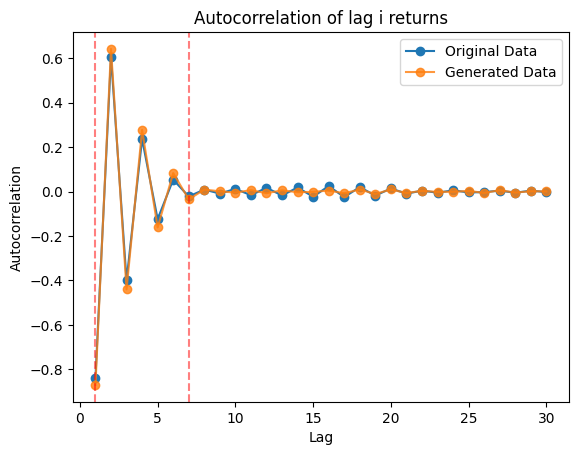

In [4]:
from statsmodels.tsa.stattools import acf

# Load the original data from the CSV file
original_samples = slices.sample(1000).values

# Calculate the lag i return for each slicing window
lag_returns_original = [np.diff(time_series, n=i) for i in range(1, 31) for time_series in original_samples]

# Calculate the autocorrelation for each lag
autocorrelations = [acf(lag_return, nlags=30, fft=True) for lag_return in lag_returns_original]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_original = np.mean(autocorrelations, axis=0)[1:]

# Load the generated data from the CSV file
generated_samples = pd.read_csv('data/generated_samples.csv').values

# Calculate the lag i return for each generated time series
lag_returns_generated = [np.diff(time_series, n=i) for i in range(1, 31) for time_series in generated_samples]

# Calculate the autocorrelation for each lag
autocorrelations_generated = [acf(lag_return, nlags=30, fft=True) for lag_return in lag_returns_generated]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_generated = np.mean(autocorrelations_generated, axis=0)[1:]

# Plot the autocorrelation for each lag
plt.plot(range(1, 31), mean_autocorrelations_original, marker='o', label='Original Data')
plt.plot(range(1, 31), mean_autocorrelations_generated, marker='o', label='Generated Data', alpha=0.8)

# Add vertical lines at lag = 1 and lag = 7
plt.axvline(x=1, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=7, color='r', linestyle='--', alpha=0.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of lag i returns')
plt.legend()
plt.show()

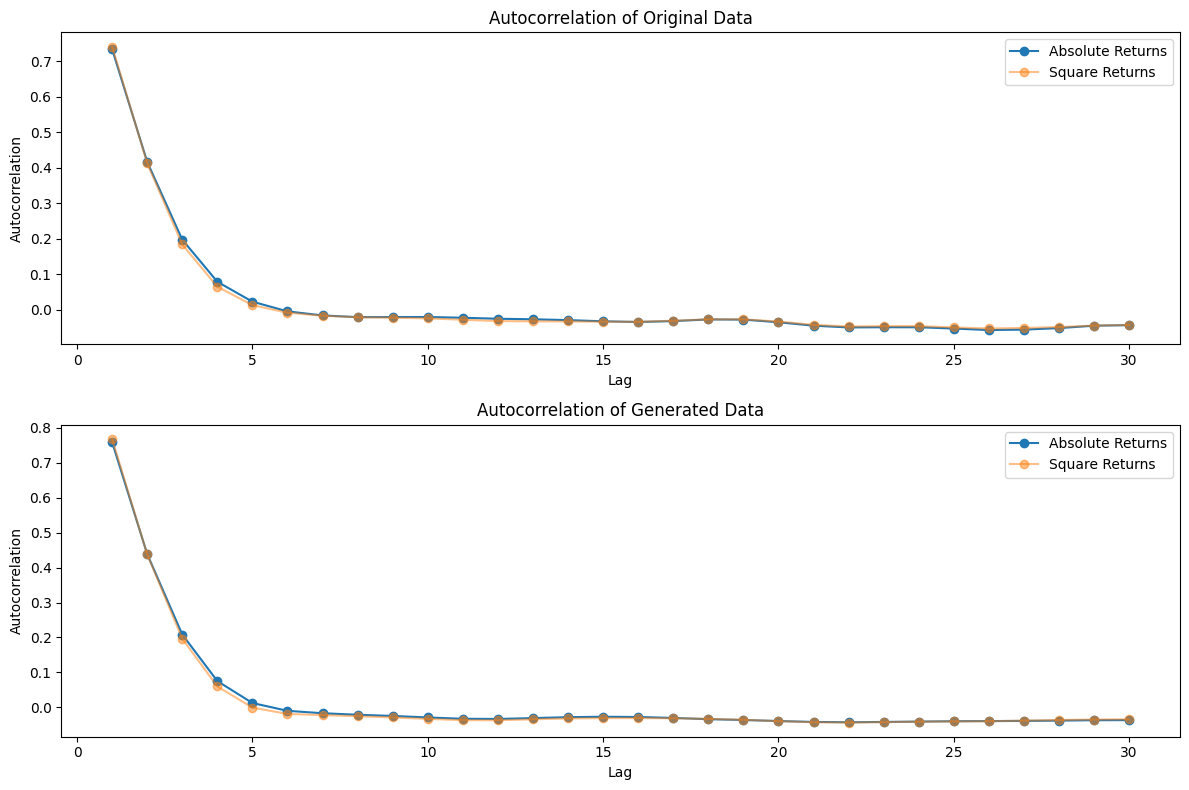

In [5]:
# Calculate the absolute and square returns
abs_returns_original = [np.abs(np.diff(time_series, n=i)) for i in range(1, 31) for time_series in original_samples]
sq_returns_original = [np.diff(time_series, n=i)**2 for i in range(1, 31) for time_series in original_samples]

abs_returns_generated = [np.abs(np.diff(time_series, n=i)) for i in range(1, 31) for time_series in generated_samples]
sq_returns_generated = [np.diff(time_series, n=i)**2 for i in range(1, 31) for time_series in generated_samples]

# Calculate the autocorrelation for each lag
autocorrelations_abs_original = [acf(abs_return, nlags=30, fft=True) for abs_return in abs_returns_original]
autocorrelations_sq_original = [acf(sq_return, nlags=30, fft=True) for sq_return in sq_returns_original]

autocorrelations_abs_generated = [acf(abs_return, nlags=30, fft=True) for abs_return in abs_returns_generated]
autocorrelations_sq_generated = [acf(sq_return, nlags=30, fft=True) for sq_return in sq_returns_generated]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_abs_original = np.mean(autocorrelations_abs_original, axis=0)[1:]
mean_autocorrelations_sq_original = np.mean(autocorrelations_sq_original, axis=0)[1:]

mean_autocorrelations_abs_generated = np.mean(autocorrelations_abs_generated, axis=0)[1:]
mean_autocorrelations_sq_generated = np.mean(autocorrelations_sq_generated, axis=0)[1:]

# Plot the autocorrelation for each lag
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(range(1, 31), mean_autocorrelations_abs_original, marker='o', label='Absolute Returns')
plt.plot(range(1, 31), mean_autocorrelations_sq_original, marker='o', label='Square Returns', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Original Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, 31), mean_autocorrelations_abs_generated, marker='o', label='Absolute Returns')
plt.plot(range(1, 31), mean_autocorrelations_sq_generated, marker='o', label='Square Returns', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Generated Data')
plt.legend()

plt.tight_layout()
plt.show()

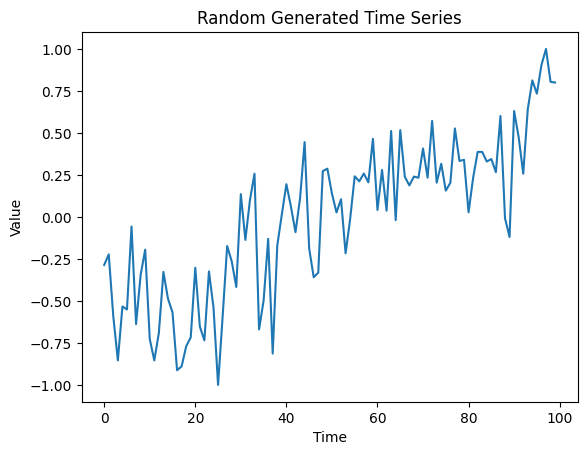

In [6]:
# Select a random time series from the generated data
random_index = np.random.randint(generated_samples.shape[0])
random_series = generated_samples[random_index]

# Plot the time series
plt.plot(random_series)
plt.title('Random Generated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()